In [1]:
import warnings
from itertools import product
import glob
from datetime import datetime
from datetime import timedelta
import numpy as np
import pandas as pd
import xarray as xr

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.path as mpath
import cartopy
import cartopy.crs as ccrs
import cartopy.feature
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader
import cartopy.feature as cf
import shapely.geometry as sgeom
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter


# from sklearn.decomposition import PCA
from scipy import stats
# from sklearn.cluster import KMeans
# from sklearn import metrics
# from scipy.spatial.distance import cdist
# from sklearn.metrics import davies_bouldin_score

import pickle
import copy
# from shapely import geometry
# from sklearn.metrics.pairwise import euclidean_distances
# import statsmodels.api as sm
from scipy.stats import linregress
# from sklearn.metrics import accuracy_score
import math
import matplotlib.lines as mlines
import matplotlib.patches as mpatches

# from scipy.stats import ks_2samp

In [2]:
import string
abcd = list(string.ascii_lowercase)

In [3]:
names_reanalyses = ['ERA5',
                   'JRA3Q',
                   'NCEP_NCAR']

In [4]:
wr=1

In [5]:
names_wrs = ["Polar High", "Pacific Trough", "Pacific Ridge", "Alaskan Ridge", "Atlantic Ridge" ,"No WR"]

In [6]:
colors_reanalyses = {'ERA5':'k','JRA3Q':'red','NCEP_NCAR':'blue'}

In [7]:
from scipy.stats import theilslopes
import statsmodels.api as sm

In [8]:
dic_labels = {}
for reanalysis in names_reanalyses:
    labels_temp = pd.read_csv(f'../ProcessZ500/labels/df_labels_nocorrfilt_{reanalysis}.csv', parse_dates=True, index_col=0, 
                              names=['WR','distances','corr'], skiprows=1)#[['WR']]
    labels_temp = labels_temp['1948':]
    labels_temp['season'] = labels_temp.index.month % 12 // 3 + 1  # This will give: 1=DJF, 2=MAM, 3=JJA, 4=SON
    # Map season numbers to season names
    season_map = {1: 'Winter', 2: 'Spring', 3: 'Summer', 4: 'Fall'}
    labels_temp['season'] = labels_temp['season'].map(season_map)
    labels_temp.loc[labels_temp['corr']<=0.2,'WR']=np.unique(labels_temp['WR'])[-1]
    dic_labels[reanalysis] = labels_temp

In [9]:
dic_events = {}

for ir, reanalysis in enumerate(names_reanalyses):
    # Compute Overall Frequency of Each Class
    df_labels = copy.deepcopy(dic_labels[reanalysis])
    
    df_labels['season'] = df_labels.index.month % 12 // 3 + 1  # This will give: 1=DJF, 2=MAM, 3=JJA, 4=SON
    # Map season numbers to season names
    season_map = {1: 'Winter', 2: 'Spring', 3: 'Summer', 4: 'Fall'}
    df_labels['season'] = df_labels['season'].map(season_map)
    
    # Step 1: Identify changes in class to find the start of each event
    df_labels['shifted'] = df_labels['WR'].shift(1)
    df_labels['start'] = df_labels['WR'] != df_labels['shifted']
    df_labels['start_date'] = df_labels.index.where(df_labels['start'], pd.NaT)
    df_labels['start_date'].fillna(method='ffill', inplace=True)
    
    # Step 2: Calculate the duration of each event
    # Convert the Timedelta to its 'days' component
    df_labels['duration'] = (df_labels.index - df_labels['start_date']).dt.days + 1
    
    # Step 3: Create the df_events DataFrame
    # Group by 'start_date' and 'class' to get the duration of each class event
    df_events = df_labels.groupby(['start_date', 'WR']).agg({'duration': 'max','corr':'mean','distances':'mean'}).reset_index()
    
    # Drop the temporary columns used for calculations
    df_labels.drop(columns=['shifted', 'start', 'start_date', 'duration'], inplace=True)
    
    # Set 'start_date' as the index if needed
    df_events.set_index('start_date', inplace=True)
    df_events['season'] = df_events.index.month % 12 // 3 + 1  # This will give: 1=DJF, 2=MAM, 3=JJA, 4=SON
    # Map season numbers to season names
    season_map = {1: 'Winter', 2: 'Spring', 3: 'Summer', 4: 'Fall'}
    df_events['season'] = df_events['season'].map(season_map)
    df_events['year'] = df_events.index.year
    # df_events = df_events[df_events['duration']>=4]
    dic_events[reanalysis] = df_events

/glade/derecho/scratch/jhayron/tmp/ipykernel_221463/2337241071.py:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_labels['start_date'].fillna(method='ffill', inplace=True)
/glade/derecho/scratch/jhayron/tmp/ipykernel_221463/2337241071.py:16: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_labels['start_date'].fillna(method='ffill', inplace=True)
/glade/derecho/scratch/jhayron/tmp/ipykernel_221463/2337241071.py:16: FutureWarning: A va

In [10]:
N=30

dic_stats_durations = {}
dic_dfs_durations = {}

for ir, reanalysis in enumerate(names_reanalyses):
    dic_stats_durations[reanalysis] = {}
    dic_dfs_durations[reanalysis] = {}
    start_year = dic_labels[reanalysis].index.year[0] + (N-1)
    end_year = dic_labels[reanalysis].index.year[-1]
    for wr in range(6):
        df_temp = copy.deepcopy(dic_events[reanalysis])
        df_temp = df_temp[(df_temp['season']=='Winter')|(df_temp['season']=='Spring')]
        df_temp = df_temp[df_temp['WR']==wr]
        
        dic_stats_temp = {}
        dic_stats_temp['mean'] = []
        dic_stats_temp['std'] = []
        dic_stats_temp['p90'] = []
        dic_stats_temp['p10'] = []
        dic_stats_temp['p95'] = []
        dic_stats_temp['p05'] = []
        dic_stats_temp['n_events'] = []
        dic_stats_temp['n_days'] = []
        
        for year in range(start_year, end_year+1):
            df_temp_temp = df_temp.loc[str(year-N+1):str(year)]['duration']
            dic_stats_temp['mean'].append(df_temp_temp.mean())
            dic_stats_temp['std'].append(df_temp_temp.std())
            dic_stats_temp['p90'].append(df_temp_temp.quantile(0.9))
            dic_stats_temp['p10'].append(df_temp_temp.quantile(0.1))
            dic_stats_temp['p95'].append(df_temp_temp.quantile(0.95))
            dic_stats_temp['p05'].append(df_temp_temp.quantile(0.05))

            dic_stats_temp['n_events'].append(len(df_temp_temp)/30)
            dic_stats_temp['n_days'].append(df_temp_temp.sum()/(30*365/2))
        df_stats_temp = pd.DataFrame(dic_stats_temp,index=np.arange(start_year,end_year+1))
        dic_stats_durations[reanalysis][f'wr{wr}'] = df_stats_temp
        dic_dfs_durations[reanalysis][f'wr{wr}'] = df_temp

In [11]:
wr=1
# Plot metrics
df_stats_temp = copy.deepcopy(dic_stats_durations['ERA5'][f'wr{wr}'])
df_events_temp = copy.deepcopy(dic_dfs_durations['ERA5'][f'wr{wr}'])
is_leap_year = df_events_temp.index.is_leap_year
total_days_in_year = np.where(is_leap_year, 366, 365)

# Convert DatetimeIndex to years in decimals
df_events_temp['year_decimal'] = (df_events_temp.index.year + (df_events_temp.index.dayofyear / total_days_in_year)).values

years = df_stats_temp.index
yearly_count = df_events_temp.groupby('year').sum()['duration']
yearly_count = yearly_count.reindex(index=np.arange(1948,2024))

In [12]:
yearly_freq = 100*yearly_count/(365/2)

In [13]:
yearly_freq = yearly_freq.fillna(0)

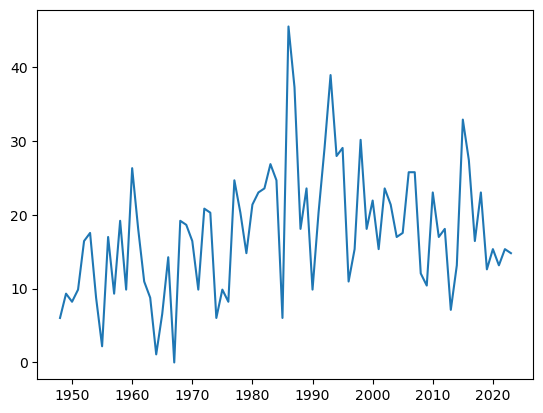

In [14]:
plt.plot(yearly_freq)

In [15]:
df_test = pd.read_csv('../ProcessZ500/labels/df_labels_nocorrfilt_ERA5.csv',
                      index_col=0,parse_dates=True)
df_test = df_test['1948-01-01':'2023-12-31']

df_test.loc[df_test['corr']<=0.2,'WR']=np.unique(df_test['WR'])[-1]#[df_test_season['WR']==wr]
df_test_season = df_test.loc[(df_test.index.month>=12)|(df_test.index.month<=5)]
df_test_season['year'] = df_test_season.index.year

/glade/derecho/scratch/jhayron/tmp/ipykernel_221463/3134943499.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_season['year'] = df_test_season.index.year


# TX>90p

In [35]:
anoms = xr.open_dataset('/glade/derecho/scratch/jhayron/Data4WRsClimateChange/Temp/TMaxp90_ERA5.nc').MaxTemp

In [36]:
temp_temp = anoms.sel(time=df_test_season['1948':'1977'].index)
composite_past = temp_temp.sum('time')/30
Np = composite_past

In [37]:
temp_temp = anoms.sel(time=df_test_season['1994':'2023'].index)
composite_present = temp_temp.sum('time')/30
Nf = composite_present

In [38]:
df_wr = df_test_season[df_test_season['WR']==wr]
print(wr)
anoms = xr.open_dataset('/glade/derecho/scratch/jhayron/Data4WRsClimateChange/Temp/TMaxp90_ERA5.nc').MaxTemp
anoms = anoms.sel(time=df_wr.index)

temp_temp = anoms.sel(time=df_wr['1948':'1977'].index)
composite_past = temp_temp.sum('time')/30
Np_forPT = composite_past

temp_temp = anoms.sel(time=df_wr['1994':'2023'].index)
composite_present = temp_temp.sum('time')/30
Nf_forPT = composite_present

1


In [39]:
df_nonwr = df_test_season[df_test_season['WR']!=wr]
print(wr)

anoms = xr.open_dataset('/glade/derecho/scratch/jhayron/Data4WRsClimateChange/Temp/TMaxp90_ERA5.nc').MaxTemp
anoms = anoms.sel(time=df_nonwr.index)

temp_temp = anoms.sel(time=df_nonwr['1948':'1977'].index)
composite_past = temp_temp.sum('time')/30
Np_nonPT = composite_past

temp_temp = anoms.sel(time=df_nonwr['1994':'2023'].index)
composite_present = temp_temp.sum('time')/30
Nf_nonPT = composite_present

1


In [40]:
freq_pt_present = yearly_freq.loc['1994':'2023'].mean()
freq_pt_past = yearly_freq.loc['1948':'1977'].mean()

In [41]:
N_days_PT_past = freq_pt_past*180/100
N_days_PT_present = freq_pt_present*180/100

In [42]:
N_days_other_past = 180-N_days_PT_past
N_days_other_present = 180-N_days_PT_present

In [43]:
# compute fractions
fPT_p = Np_forPT/N_days_PT_past
fPT_f = Nf_forPT/N_days_PT_present

In [44]:
fo_p = Np_nonPT/N_days_other_past
fo_f = Nf_nonPT/N_days_other_present

In [45]:
delta_f_PT = fPT_f - fPT_p
delta_N_PT = N_days_PT_present - N_days_PT_past
delta_Nh_PT = Nf_forPT - Np_forPT 

In [46]:
delta_f_o = fo_f-fo_p

In [47]:
delta_f_prime_PT = delta_f_PT - delta_f_o

In [48]:
# Term 1 - effect of overall w-s increase in events for the past frequency
a1 = N_days_PT_past * delta_f_o

# Term 2 - effect of increase in events per day exclusive for the PT (apart from the mean)
a2 = delta_f_o * delta_N_PT

# Term 3 - linear effect of increase in frequency
a3 = delta_N_PT * fo_p

# Term 4 - linear effect of increase in frequency
a4 = delta_N_PT * (fPT_p-fo_p)

# Term 5 - effect of increase in events per day exclusive for the PT (apart from the mean)
a5 = N_days_PT_past * delta_f_prime_PT

# Term 6 - nonlinear effect of increase in PT frequency and increase in extremes per day 
# apart from the overall increase (exclusive for the PT)
a6 = delta_f_prime_PT * delta_N_PT

In [49]:
# seasonal increase PT part

In [50]:
B_PT = fPT_f * N_days_PT_present - fPT_p * N_days_PT_past
B_nonPT = fo_f * N_days_other_present - fo_p * N_days_other_past

In [54]:
dic_extremes_decomposition = {'a1':a1,
    'a2':a2,
    'a3':a3,
    'a4':a4,
    'a5':a5,
    'a6':a6,
    'b_PT':B_PT,
    'b_nonPT':B_nonPT,
    'Np':Np,
    'delta_f_o': delta_f_o,
    'delta_f_PT': delta_f_PT}

In [55]:
ds_extremes_decomposition = xr.Dataset(dic_extremes_decomposition)

In [56]:
ds_extremes_decomposition.to_netcdf('diffs_extremes/ds_extremes_tx90p_v2.nc')

# ws

In [57]:
anoms = xr.open_dataset('/glade/derecho/scratch/jhayron/Data4WRsClimateChange/Temp/warm_spells_v2.nc').start_durations

In [58]:
temp_temp = anoms.sel(time=df_test_season['1948':'1977'].index)
composite_past = temp_temp.sum('time')/30
Np = composite_past

In [59]:
temp_temp = anoms.sel(time=df_test_season['1994':'2023'].index)
composite_present = temp_temp.sum('time')/30
Nf = composite_present

In [60]:
df_wr = df_test_season[df_test_season['WR']==wr]
print(wr)
anoms = xr.open_dataset('/glade/derecho/scratch/jhayron/Data4WRsClimateChange/Temp/warm_spells_v2.nc').start_durations
anoms = anoms.sel(time=df_wr.index)

temp_temp = anoms.sel(time=df_wr['1948':'1977'].index)
composite_past = temp_temp.sum('time')/30
Np_forPT = composite_past

temp_temp = anoms.sel(time=df_wr['1994':'2023'].index)
composite_present = temp_temp.sum('time')/30
Nf_forPT = composite_present

1


In [61]:
df_nonwr = df_test_season[df_test_season['WR']!=wr]
print(wr)

anoms = xr.open_dataset('/glade/derecho/scratch/jhayron/Data4WRsClimateChange/Temp/warm_spells_v2.nc').start_durations
anoms = anoms.sel(time=df_nonwr.index)

temp_temp = anoms.sel(time=df_nonwr['1948':'1977'].index)
composite_past = temp_temp.sum('time')/30
Np_nonPT = composite_past

temp_temp = anoms.sel(time=df_nonwr['1994':'2023'].index)
composite_present = temp_temp.sum('time')/30
Nf_nonPT = composite_present

1


In [62]:
freq_pt_present = yearly_freq.loc['1994':'2023'].mean()
freq_pt_past = yearly_freq.loc['1948':'1977'].mean()

In [63]:
N_days_PT_past = freq_pt_past*180/100
N_days_PT_present = freq_pt_present*180/100

In [64]:
N_days_other_past = 180-N_days_PT_past
N_days_other_present = 180-N_days_PT_present

In [65]:
# compute fractions
fPT_p = Np_forPT/N_days_PT_past
fPT_f = Nf_forPT/N_days_PT_present

In [66]:
fo_p = Np_nonPT/N_days_other_past
fo_f = Nf_nonPT/N_days_other_present

In [67]:
delta_f_PT = fPT_f - fPT_p
delta_N_PT = N_days_PT_present - N_days_PT_past
delta_Nh_PT = Nf_forPT - Np_forPT 

In [68]:
delta_f_o = fo_f-fo_p

In [69]:
delta_f_prime_PT = delta_f_PT - delta_f_o

In [70]:
# Term 1 - effect of overall w-s increase in events for the past frequency
a1 = N_days_PT_past * delta_f_o

# Term 2 - effect of increase in events per day exclusive for the PT (apart from the mean)
a2 = delta_f_o * delta_N_PT

# Term 3 - linear effect of increase in frequency
a3 = delta_N_PT * fo_p

# Term 4 - linear effect of increase in frequency
a4 = delta_N_PT * (fPT_p-fo_p)

# Term 5 - effect of increase in events per day exclusive for the PT (apart from the mean)
a5 = N_days_PT_past * delta_f_prime_PT

# Term 6 - nonlinear effect of increase in PT frequency and increase in extremes per day 
# apart from the overall increase (exclusive for the PT)
a6 = delta_f_prime_PT * delta_N_PT

In [71]:
# seasonal increase PT part

In [72]:
B_PT = fPT_f * N_days_PT_present - fPT_p * N_days_PT_past
B_nonPT = fo_f * N_days_other_present - fo_p * N_days_other_past

In [73]:
dic_extremes_decomposition = {'a1':a1,
    'a2':a2,
    'a3':a3,
    'a4':a4,
    'a5':a5,
    'a6':a6,
    'b_PT':B_PT,
    'b_nonPT':B_nonPT,
    'Np':Np,
    'delta_f_o': delta_f_o,
    'delta_f_PT': delta_f_PT}

In [74]:
ds_extremes_decomposition = xr.Dataset(dic_extremes_decomposition)

In [75]:
ds_extremes_decomposition.to_netcdf('diffs_extremes/ds_extremes_ws_v2.nc')

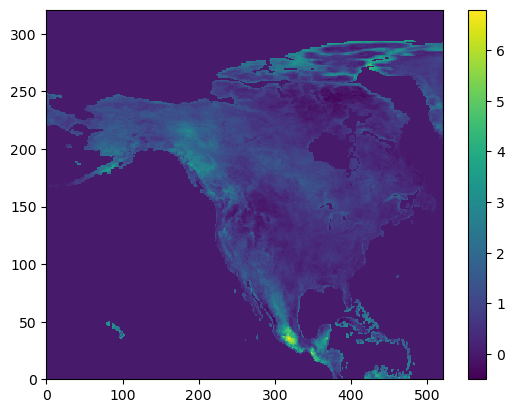

In [143]:
plt.pcolormesh(B_PT+B_nonPT)
plt.colorbar()

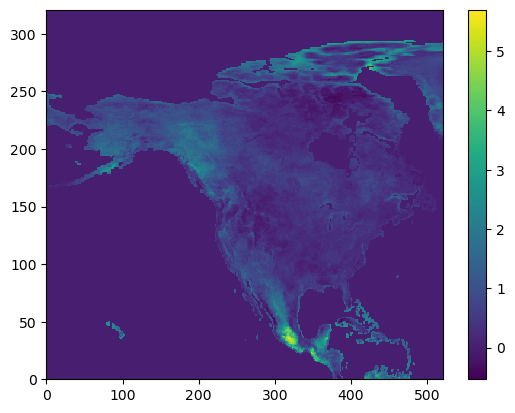

In [145]:
plt.pcolormesh(B_nonPT)
plt.colorbar()

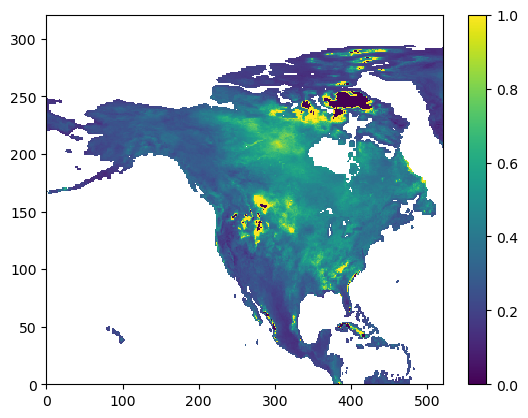

In [112]:
plt.pcolormesh(B_PT/(B_PT+B_nonPT),vmin=0,vmax=1)
plt.colorbar()

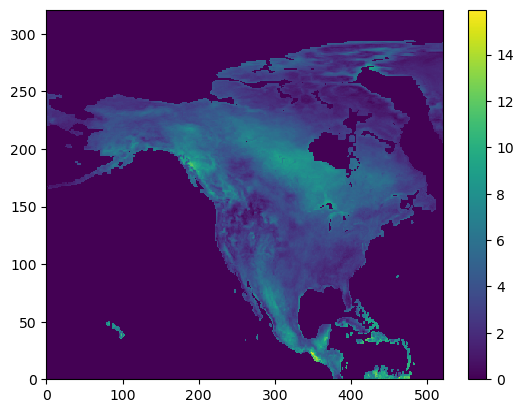

In [107]:
plt.pcolormesh(B_PT)
plt.colorbar()

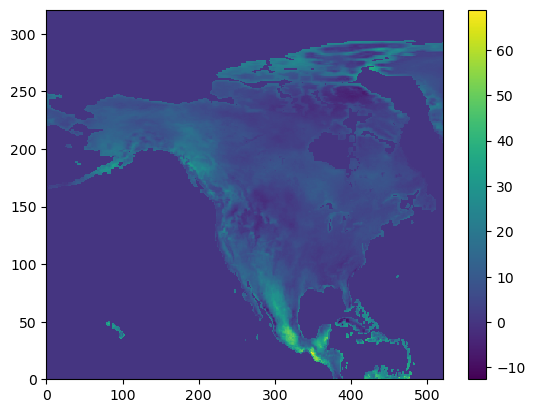

In [109]:
plt.pcolormesh(B_nonPT)
plt.colorbar()

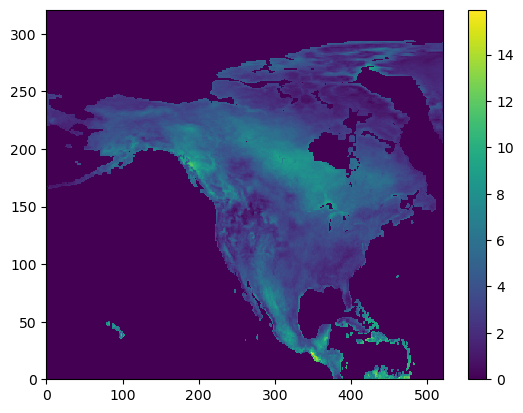

In [100]:
plt.pcolormesh(a1+a2+a3+a4+a5)
plt.colorbar()

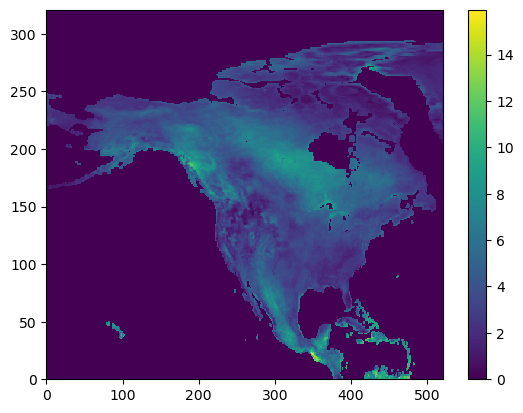

In [81]:
plt.pcolormesh(delta_Nh_PT)
plt.colorbar()

# just the three terms

In [ ]:
a1 = N_days_PT_past * delta_f_PT
a2 = fPT_p * delta_N_PT

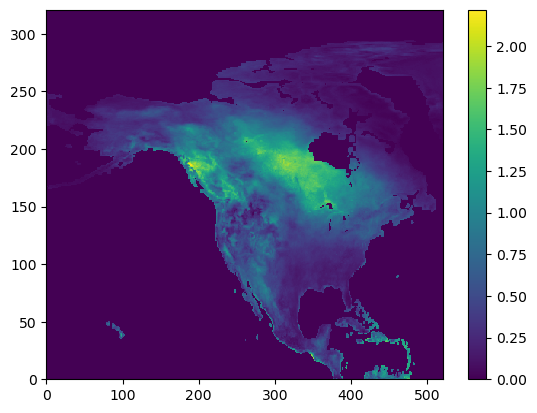

In [36]:
plt.pcolormesh(a3)
plt.colorbar()

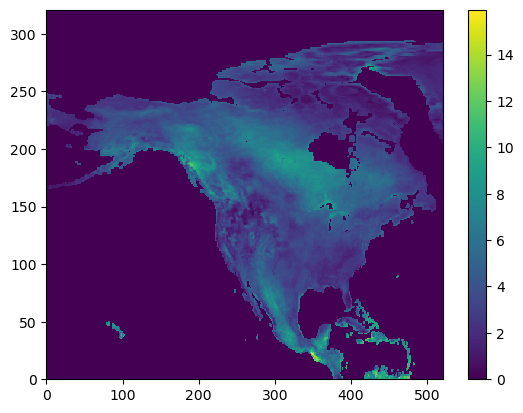

In [32]:
plt.pcolormesh(delta_N_PT)
plt.colorbar()

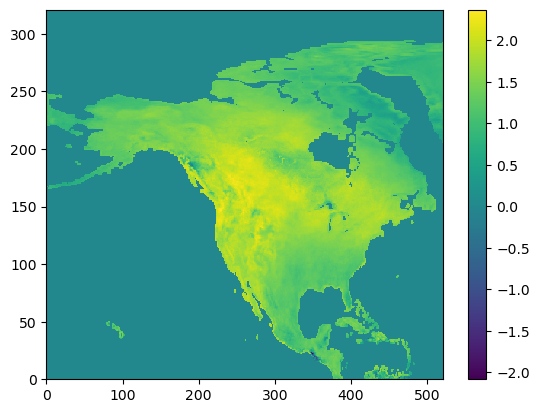

In [31]:
plt.pcolormesh(delta_N_PT - (a1+a2+a3+a4+a5) )
plt.colorbar()

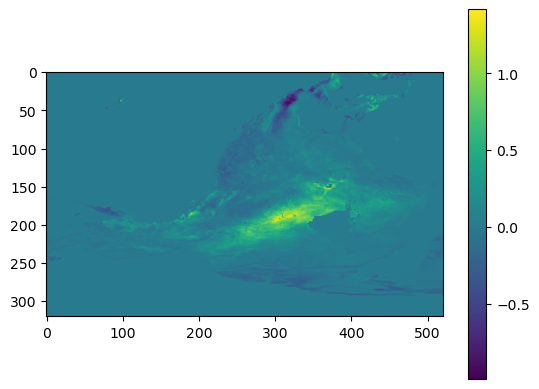

In [76]:
plt.imshow(a5)
plt.colorbar()

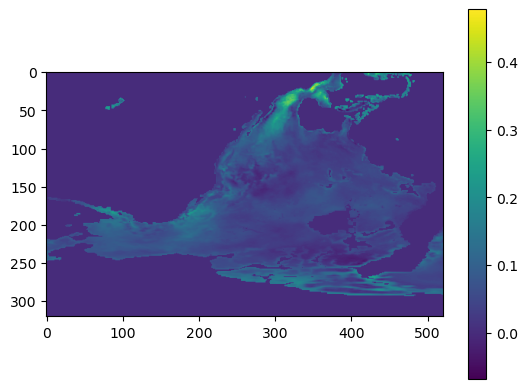

In [52]:
plt.imshow(fo_f-fo_p)
plt.colorbar()

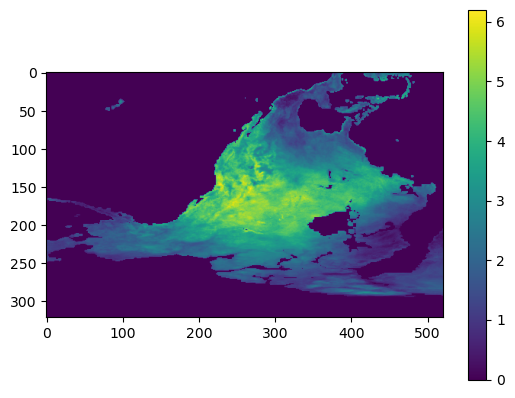

In [32]:
plt.imshow(Np_forPT/)
plt.colorbar()

## B. Change in events during winter-spring

In [87]:
anoms = xr.open_dataset('/glade/derecho/scratch/jhayron/Data4WRsClimateChange/Temp/TMaxp90_ERA5.nc').MaxTemp
temp_temp = anoms.sel(time=df_test_season['1948':'1977'].index)
composite_past = temp_temp.sum('time')/30
temp_temp = anoms.sel(time=df_test_season['1994':'2023'].index)
composite_present = temp_temp.sum('time')/30
diff = composite_present-composite_past

Text(0.5, 1.0, 'B. Average change in events during winter-spring (ChEv_WS)')

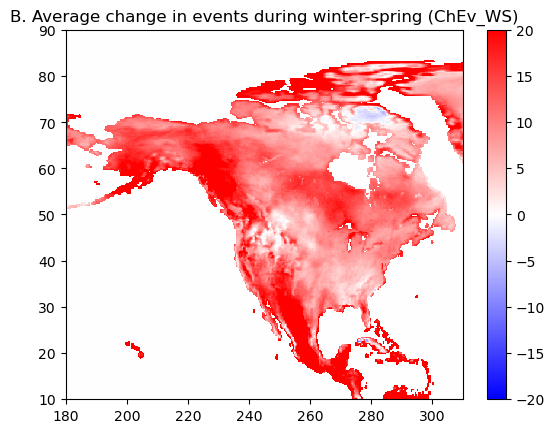

In [88]:
plt.pcolormesh(diff.lon,diff.lat,diff,vmin=-20,vmax=20,cmap='bwr')
plt.colorbar()
plt.title('B. Average change in events during winter-spring (ChEv_WS)')


In [89]:
diff.to_netcdf('diffs_extremes/tx90p_B.nc')

## A. Change in events during PT

In [90]:
df_wr = df_test_season[df_test_season['WR']==wr]
print(wr)

1


In [91]:
anoms = xr.open_dataset('/glade/derecho/scratch/jhayron/Data4WRsClimateChange/Temp/TMaxp90_ERA5.nc').MaxTemp
anoms = anoms.sel(time=df_wr.index)

temp_temp = anoms.sel(time=df_wr['1948':'1977'].index)
composite_past = temp_temp.sum('time')/30
temp_temp = anoms.sel(time=df_wr['1994':'2023'].index)
composite_present = temp_temp.sum('time')/30
diff_pt = composite_present-composite_past

Text(0.5, 1.0, 'A. Average change in events during PT (ChEv_PT)')

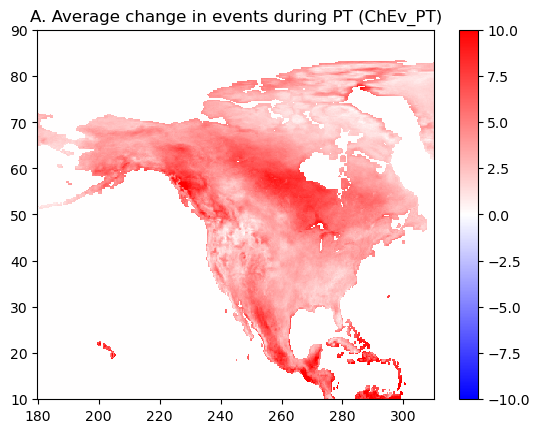

In [92]:
plt.pcolormesh(diff.lon,diff.lat,diff_pt,vmin=-10,vmax=10,cmap='bwr')
plt.colorbar()
plt.title('A. Average change in events during PT (ChEv_PT)')


In [93]:
diff_pt.to_netcdf('diffs_extremes/tx90p_A.nc')

## A1. Change in events during a PT due to the mean increase

In [94]:
freq_pt_present = yearly_freq.loc['1994':'2023'].mean()
freq_pt_past = yearly_freq.loc['1948':'1977'].mean()

In [95]:
A1 = diff * freq_pt_present/100

In [96]:
# plt.pcolormesh(A1,vmin=-10,vmax=10,cmap='bwr')
# plt.colorbar()
# plt.title('A1. Average change in events during PT\ndue to mean winter-spring increase')


### Average change of # of events during non-PT days

In [97]:
df_nonwr = df_test_season[df_test_season['WR']!=wr]
print(wr)

1


In [98]:
anoms = xr.open_dataset('/glade/derecho/scratch/jhayron/Data4WRsClimateChange/Temp/TMaxp90_ERA5.nc').MaxTemp
anoms = anoms.sel(time=df_nonwr.index)

temp_temp = anoms.sel(time=df_nonwr['1948':'1977'].index)
composite_past = temp_temp.sum('time')/30
temp_temp = anoms.sel(time=df_nonwr['1994':'2023'].index)
composite_present = temp_temp.sum('time')/30
diff_nonpt = composite_present-composite_past

In [99]:
diff_nonpt_perday = (composite_present/(180*(1-freq_pt_present/100))) - \
    (composite_past/(180*(1-freq_pt_past/100)))

In [100]:
# plt.pcolormesh(diff_nonpt_perday,vmin=-0.2,vmax=0.2,cmap='bwr')
# plt.colorbar()
# plt.title('Average change in events during non PT days (ChEv_PT)')


In [101]:
A1v2 = diff_nonpt_perday * 180 * freq_pt_present/100

Text(0.5, 1.0, 'A1. Average change in events during PT\ndue to mean winter-spring increase')

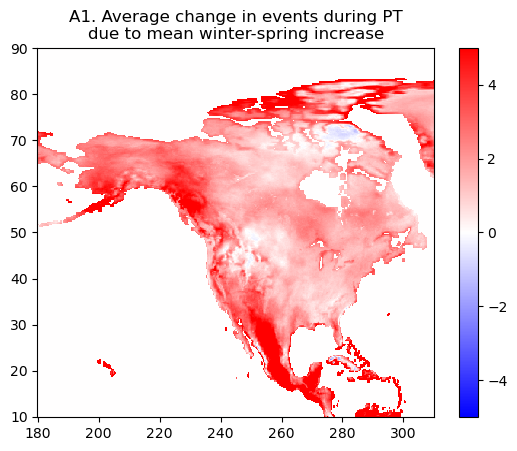

In [102]:
plt.pcolormesh(diff.lon,diff.lat,A1v2,vmin=-5,vmax=5,cmap='bwr')
plt.colorbar()
plt.title('A1. Average change in events during PT\ndue to mean winter-spring increase')


In [103]:
A1v2.to_netcdf('diffs_extremes/tx90p_A1.nc')

### Average change of # of events during PT days

In [104]:
df_wr = df_test_season[df_test_season['WR']==wr]
print(wr)

1


In [105]:
anoms = xr.open_dataset('/glade/derecho/scratch/jhayron/Data4WRsClimateChange/Temp/TMaxp90_ERA5.nc').MaxTemp
anoms = anoms.sel(time=df_wr.index)

temp_temp = anoms.sel(time=df_wr['1948':'1977'].index)
composite_past = temp_temp.sum('time')/30
temp_temp = anoms.sel(time=df_wr['1994':'2023'].index)
composite_present = temp_temp.sum('time')/30
diff_pt = composite_present-composite_past

In [106]:
diff_pt_perday = (composite_present/(180*(freq_pt_present/100))) - \
    (composite_past/(180*(freq_pt_past/100)))

In [107]:
# plt.pcolormesh(diff_pt_perday,vmin=-0.2,vmax=0.2,cmap='bwr')
# plt.colorbar()
# plt.title('Average change in events during PT days (ChEv_PT)')


In [108]:
# plt.pcolormesh(diff_pt_perday-diff_nonpt_perday,vmin=-0.2,vmax=0.2,cmap='bwr')
# plt.colorbar()
# plt.title('Average change in events during PT days (ChEv_PT--nonfreq exclusive for PT)')


## A2. Change in events during a PT due to the frequency increase

In [109]:
df_wr = df_test_season[df_test_season['WR']==wr]
print(wr)

1


In [110]:
anoms = xr.open_dataset('/glade/derecho/scratch/jhayron/Data4WRsClimateChange/Temp/TMaxp90_ERA5.nc').MaxTemp
anoms = anoms.sel(time=df_wr.index)

temp_temp = anoms.sel(time=df_wr['1948':'1977'].index)
composite_past = temp_temp.sum('time')/30

In [111]:
A2 = composite_past * (1+ (freq_pt_present-freq_pt_past)/freq_pt_past) - composite_past
#Ev_PT_past * [1 + (PT_freq_present-PT_freq_past)/PT_freq_past]

Text(0.5, 1.0, 'A2. Average change in events during PT\ndue to frequency increase')

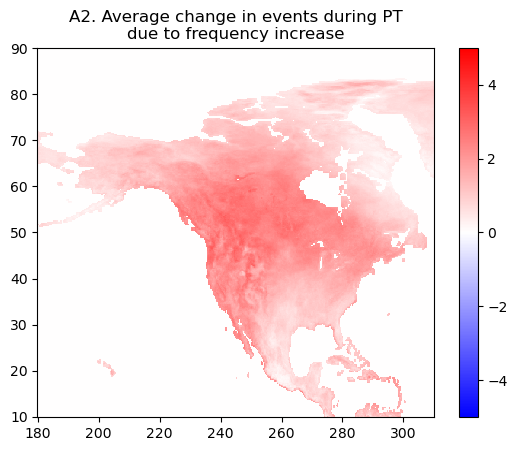

In [112]:
plt.pcolormesh(diff.lon,diff.lat,A2,vmin=-5,vmax=5,cmap='bwr')
plt.colorbar()
plt.title('A2. Average change in events during PT\ndue to frequency increase')


In [113]:
A2.to_netcdf('diffs_extremes/tx90p_A2.nc')

# A3. Change in events during a PT due nonlinearities or changes in PT characteristics

In [114]:
A3 = diff_pt-A1v2-A2

In [115]:
# plt.pcolormesh(A3,vmin=-10,vmax=10,cmap='bwr')
# plt.colorbar()
# plt.title('A3. Average change in events during PT\ndue to nonlinearities')


In [116]:
temp_temp = anoms.sel(time=df_wr['1994':'2023'].index)
composite_present = temp_temp.sum('time')/30

In [117]:
A3v2_pt1 = (1/180) * ((composite_present/freq_pt_present)-(composite_past/freq_pt_past))

In [118]:
A3v2_pt2 = diff/180

In [119]:
A3v2_pt3 = freq_pt_present*180/100

In [120]:
A3v2 = (A3v2_pt1 - A3v2_pt2) * A3v2_pt3

In [121]:
A3v3 = (diff_pt_perday-diff_nonpt_perday)*180* freq_pt_present/100

In [122]:
A3v3.to_netcdf('diffs_extremes/tx90p_A3.nc')

In [123]:
# plt.pcolormesh(A3v2,vmin=-10,vmax=10,cmap='bwr')
# plt.colorbar()
# plt.title('A3v2. Average change in events during PT\ndue to nonlinearities')


Text(0.5, 1.0, 'A3. Average change in events during PT\ndue to nonlinearities')

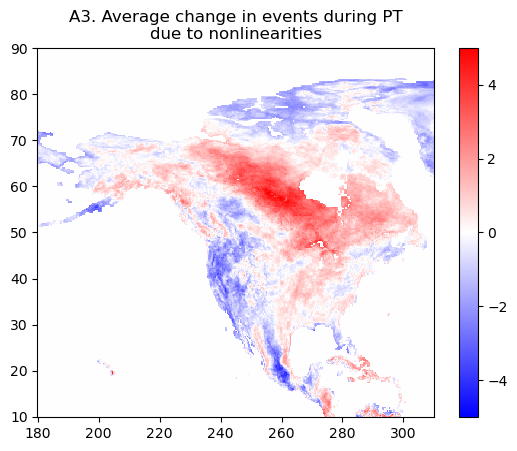

In [124]:
plt.pcolormesh(diff.lon,diff.lat,A3v3,vmin=-5,vmax=5,cmap='bwr')
plt.colorbar()
plt.title('A3. Average change in events during PT\ndue to nonlinearities')


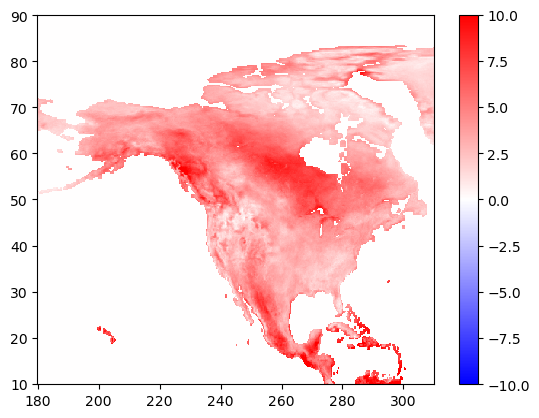

In [125]:
A_estimated = A1v2+(A2)+A3v3
plt.pcolormesh(diff.lon,diff.lat,A_estimated,vmin=-10,vmax=10,cmap='bwr')
plt.colorbar()

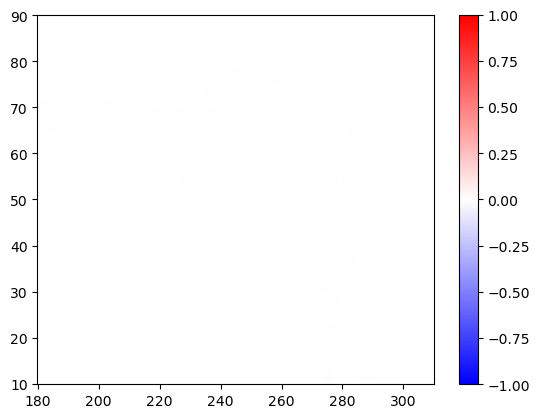

In [126]:
plt.pcolormesh(diff.lon,diff.lat,(A_estimated-diff_pt)/diff_pt,vmin=-1,vmax=1,cmap='bwr')
plt.colorbar()

## B1

Text(0.5, 1.0, 'B. Average change in events during winter-spring (ChEv_WS)')

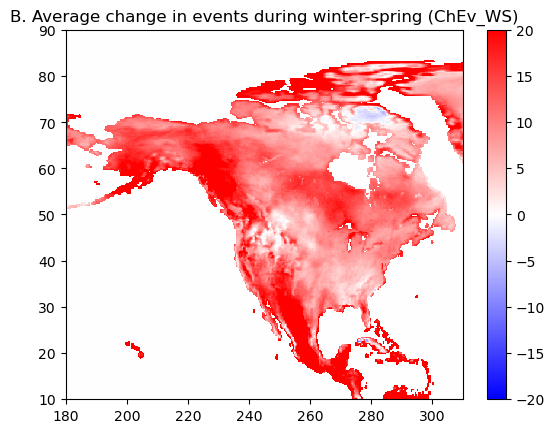

In [127]:
plt.pcolormesh(diff.lon,diff.lat,diff,vmin=-20,vmax=20,cmap='bwr')
plt.colorbar()
plt.title('B. Average change in events during winter-spring (ChEv_WS)')


In [128]:
B1 = diff_nonpt_perday * 180

Text(0.5, 1.0, 'B1. Mean (non-PT) increase')

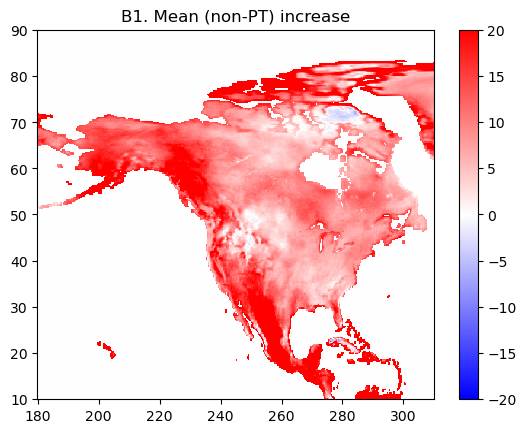

In [129]:
plt.pcolormesh(diff.lon,diff.lat,B1,vmin=-20,vmax=20,cmap='bwr')
plt.colorbar()
plt.title('B1. Mean (non-PT) increase')


In [130]:
B1.to_netcdf('diffs_extremes/tx90p_B1.nc')

In [131]:
B2 = (A2)+A3v3

In [132]:
B2.to_netcdf('diffs_extremes/tx90p_B2.nc')

Text(0.5, 1.0, 'B2. PT-related (frequency+nonlinearity) increase')

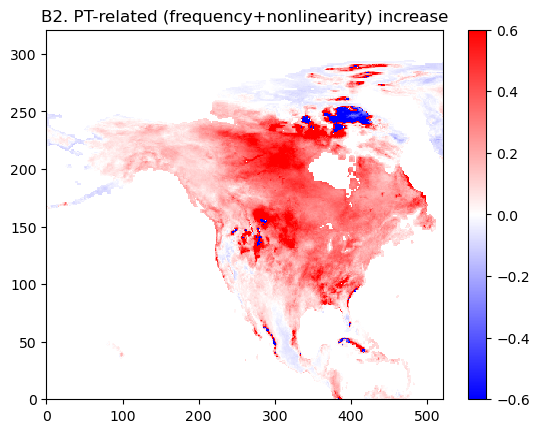

In [133]:
plt.pcolormesh(B2/diff,vmin=-0.6,vmax=0.6,cmap='bwr')
plt.colorbar()
plt.title('B2. PT-related (frequency+nonlinearity) increase')


Text(0.5, 1.0, 'B2. PT-related (frequency+nonlinearity) increase')

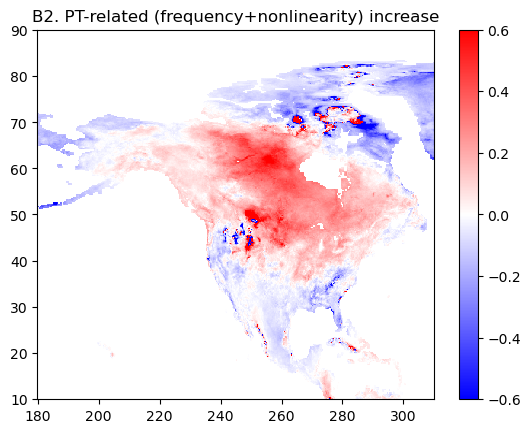

In [134]:
plt.pcolormesh(diff.lon,diff.lat,(diff-B1)/diff,vmin=-0.6,vmax=0.6,cmap='bwr')
plt.colorbar()
plt.title('B2. PT-related (frequency+nonlinearity) increase')


Text(0.5, 1.0, 'B2. PT-related (frequency+nonlinearity) increase')

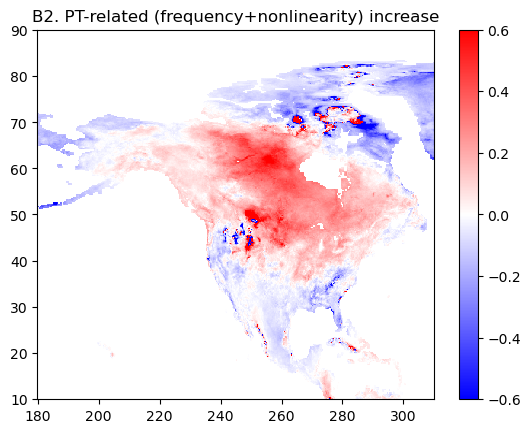

In [135]:
plt.pcolormesh(diff.lon,diff.lat,(diff-B1)/diff,vmin=-0.6,vmax=0.6,cmap='bwr')
plt.colorbar()
plt.title('B2. PT-related (frequency+nonlinearity) increase')


In [136]:
diff

<xarray.DataArray 'MaxTemp' (lat: 321, lon: 521)> Size: 1MB
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])
Coordinates:
  * lat       (lat) float64 3kB 10.0 10.25 10.5 10.75 ... 89.25 89.5 89.75 90.0
  * lon       (lon) float64 4kB 180.0 180.2 180.5 180.8 ... 309.5 309.8 310.0
    quantile  float64 8B 0.9

# Warm spells

## B. Change in events during winter-spring

In [137]:
anoms = xr.open_dataset('/glade/derecho/scratch/jhayron/Data4WRsClimateChange/Temp/warm_spells_v2.nc').start_durations
temp_temp = anoms.sel(time=df_test_season['1948':'1977'].index)
composite_past = temp_temp.sum('time')/30
temp_temp = anoms.sel(time=df_test_season['1994':'2023'].index)
composite_present = temp_temp.sum('time')/30
diff = composite_present-composite_past

In [138]:
diff.to_netcdf('diffs_extremes/ws_B.nc')

Text(0.5, 1.0, 'B. Average change in events during winter-spring (ChEv_WS)')

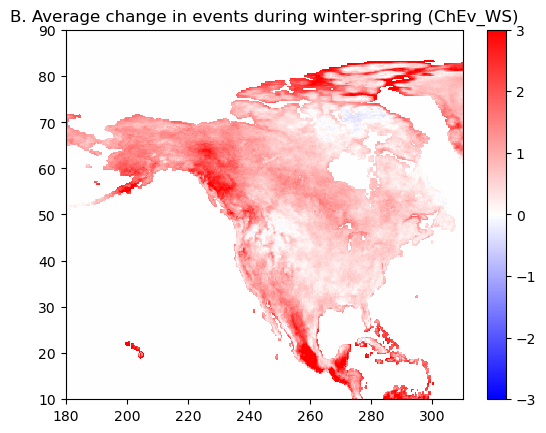

In [139]:
plt.pcolormesh(diff.lon,diff.lat,diff,vmin=-3,vmax=3,cmap='bwr')
plt.colorbar()
plt.title('B. Average change in events during winter-spring (ChEv_WS)')


## A. Change in events during PT

In [140]:
df_wr = df_test_season[df_test_season['WR']==wr]
print(wr)

1


In [141]:
anoms = xr.open_dataset('/glade/derecho/scratch/jhayron/Data4WRsClimateChange/Temp/warm_spells_v2.nc').start_durations
anoms = anoms.sel(time=df_wr.index)

temp_temp = anoms.sel(time=df_wr['1948':'1977'].index)
composite_past = temp_temp.sum('time')/30
temp_temp = anoms.sel(time=df_wr['1994':'2023'].index)
composite_present = temp_temp.sum('time')/30
diff_pt = composite_present-composite_past

In [182]:
diff_pt.to_netcdf('diffs_extremes/ws_A.nc')

Text(0.5, 1.0, 'A. Average change in events during PT (ChEv_PT)')

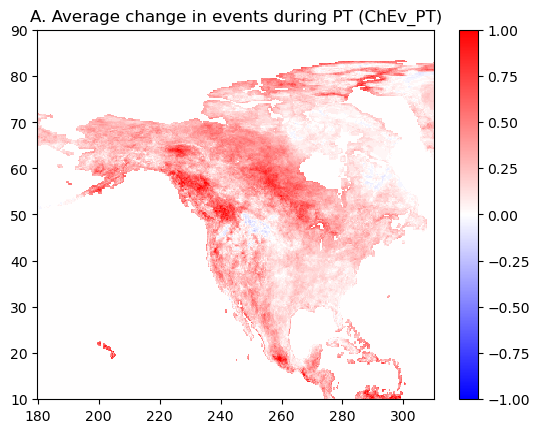

In [142]:
plt.pcolormesh(diff.lon,diff.lat,diff_pt,vmin=-1,vmax=1,cmap='bwr')
plt.colorbar()
plt.title('A. Average change in events during PT (ChEv_PT)')


## A1. Change in events during a PT due to the mean increase

In [143]:
freq_pt_present = yearly_freq.loc['1994':'2023'].mean()
freq_pt_past = yearly_freq.loc['1948':'1977'].mean()

In [144]:
A1 = diff * freq_pt_present/100

In [145]:
# plt.pcolormesh(A1,vmin=-10,vmax=10,cmap='bwr')
# plt.colorbar()
# plt.title('A1. Average change in events during PT\ndue to mean winter-spring increase')


### Average change of # of events during non-PT days

In [146]:
df_nonwr = df_test_season[df_test_season['WR']!=wr]
print(wr)

1


In [147]:
anoms = xr.open_dataset('/glade/derecho/scratch/jhayron/Data4WRsClimateChange/Temp/warm_spells_v2.nc').start_durations
anoms = anoms.sel(time=df_nonwr.index)

temp_temp = anoms.sel(time=df_nonwr['1948':'1977'].index)
composite_past = temp_temp.sum('time')/30
temp_temp = anoms.sel(time=df_nonwr['1994':'2023'].index)
composite_present = temp_temp.sum('time')/30
diff_nonpt = composite_present-composite_past

In [148]:
diff_nonpt_perday = (composite_present/(180*(1-freq_pt_present/100))) - \
    (composite_past/(180*(1-freq_pt_past/100)))

In [149]:
# plt.pcolormesh(diff_nonpt_perday,vmin=-0.2,vmax=0.2,cmap='bwr')
# plt.colorbar()
# plt.title('Average change in events during non PT days (ChEv_PT)')


In [150]:
A1v2 = diff_nonpt_perday * 180 * freq_pt_present/100

Text(0.5, 1.0, 'A1. Average change in events during PT\ndue to mean winter-spring increase')

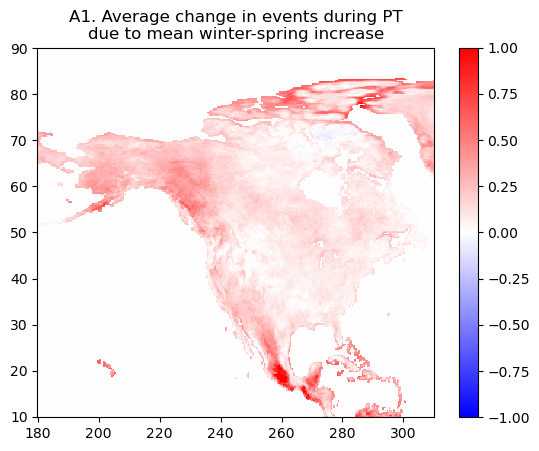

In [151]:
plt.pcolormesh(diff.lon,diff.lat,A1v2,vmin=-1,vmax=1,cmap='bwr')
plt.colorbar()
plt.title('A1. Average change in events during PT\ndue to mean winter-spring increase')


In [152]:
A1v2.to_netcdf('diffs_extremes/ws_A1.nc')

### Average change of # of events during PT days

In [153]:
df_wr = df_test_season[df_test_season['WR']==wr]
print(wr)

1


In [154]:
anoms = xr.open_dataset('/glade/derecho/scratch/jhayron/Data4WRsClimateChange/Temp/warm_spells_v2.nc').start_durations
anoms = anoms.sel(time=df_wr.index)

temp_temp = anoms.sel(time=df_wr['1948':'1977'].index)
composite_past = temp_temp.sum('time')/30
temp_temp = anoms.sel(time=df_wr['1994':'2023'].index)
composite_present = temp_temp.sum('time')/30
diff_pt = composite_present-composite_past

In [155]:
diff_pt_perday = (composite_present/(180*(freq_pt_present/100))) - \
    (composite_past/(180*(freq_pt_past/100)))

In [156]:
# plt.pcolormesh(diff_pt_perday,vmin=-0.2,vmax=0.2,cmap='bwr')
# plt.colorbar()
# plt.title('Average change in events during PT days (ChEv_PT)')


In [157]:
# plt.pcolormesh(diff_pt_perday-diff_nonpt_perday,vmin=-0.2,vmax=0.2,cmap='bwr')
# plt.colorbar()
# plt.title('Average change in events during PT days (ChEv_PT--nonfreq exclusive for PT)')


## A2. Change in events during a PT due to the frequency increase

In [158]:
df_wr = df_test_season[df_test_season['WR']==wr]
print(wr)

1


In [159]:
anoms = xr.open_dataset('/glade/derecho/scratch/jhayron/Data4WRsClimateChange/Temp/warm_spells_v2.nc').start_durations
anoms = anoms.sel(time=df_wr.index)

temp_temp = anoms.sel(time=df_wr['1948':'1977'].index)
composite_past = temp_temp.sum('time')/30

In [160]:
A2 = composite_past * (1+ (freq_pt_present-freq_pt_past)/freq_pt_past) - composite_past
#Ev_PT_past * [1 + (PT_freq_present-PT_freq_past)/PT_freq_past]

Text(0.5, 1.0, 'A2. Average change in events during PT\ndue to frequency increase')

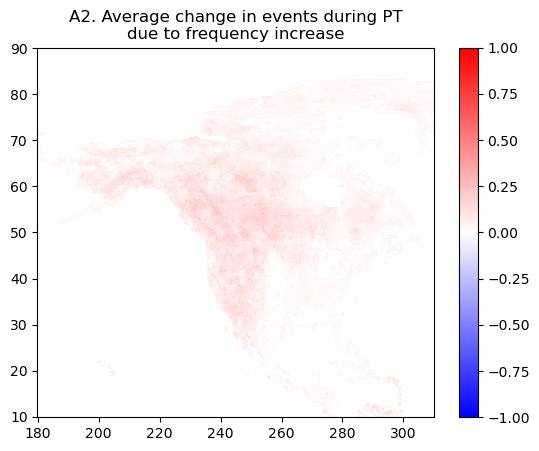

In [161]:
plt.pcolormesh(diff.lon,diff.lat,A2,vmin=-1,vmax=1,cmap='bwr')
plt.colorbar()
plt.title('A2. Average change in events during PT\ndue to frequency increase')


In [162]:
A2.to_netcdf('diffs_extremes/ws_A2.nc')

# A3. Change in events during a PT due nonlinearities or changes in PT characteristics

In [163]:
A3 = diff_pt-A1v2-A2

In [164]:
# plt.pcolormesh(A3,vmin=-10,vmax=10,cmap='bwr')
# plt.colorbar()
# plt.title('A3. Average change in events during PT\ndue to nonlinearities')


In [165]:
temp_temp = anoms.sel(time=df_wr['1994':'2023'].index)
composite_present = temp_temp.sum('time')/30

In [166]:
A3v2_pt1 = (1/180) * ((composite_present/freq_pt_present)-(composite_past/freq_pt_past))

In [167]:
A3v2_pt2 = diff/180

In [168]:
A3v2_pt3 = freq_pt_present*180/100

In [169]:
A3v2 = (A3v2_pt1 - A3v2_pt2) * A3v2_pt3

In [170]:
A3v3 = (diff_pt_perday-diff_nonpt_perday)*180* freq_pt_present/100

In [171]:
# plt.pcolormesh(A3v2,vmin=-10,vmax=10,cmap='bwr')
# plt.colorbar()
# plt.title('A3v2. Average change in events during PT\ndue to nonlinearities')


Text(0.5, 1.0, 'A3. Average change in events during PT\ndue to nonlinearities')

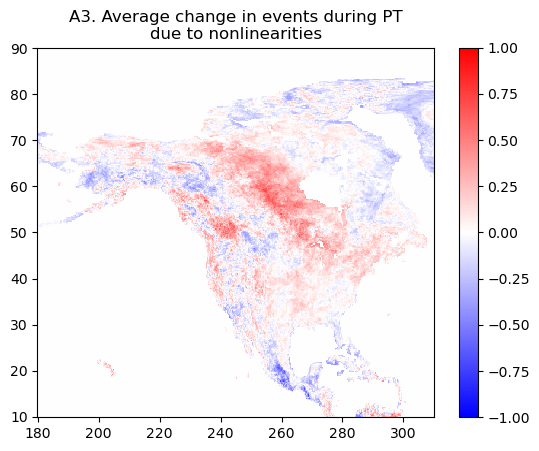

In [172]:
plt.pcolormesh(diff.lon,diff.lat,A3v3,vmin=-1,vmax=1,cmap='bwr')
plt.colorbar()
plt.title('A3. Average change in events during PT\ndue to nonlinearities')


In [173]:
A3v3.to_netcdf('diffs_extremes/ws_A3.nc')

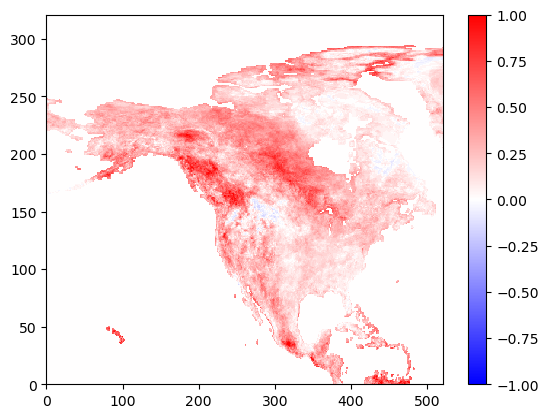

In [174]:
A_estimated = A1v2+(A2)+A3v3
plt.pcolormesh(A_estimated,vmin=-1,vmax=1,cmap='bwr')
plt.colorbar()

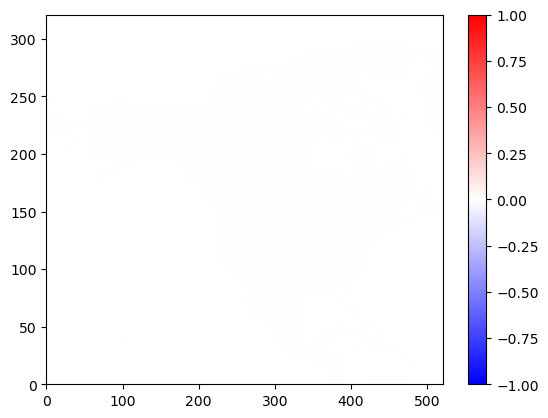

In [175]:
plt.pcolormesh((A_estimated-diff_pt)/diff_pt,vmin=-1,vmax=1,cmap='bwr')
plt.colorbar()

## B1

Text(0.5, 1.0, 'B. Average change in events during winter-spring (ChEv_WS)')

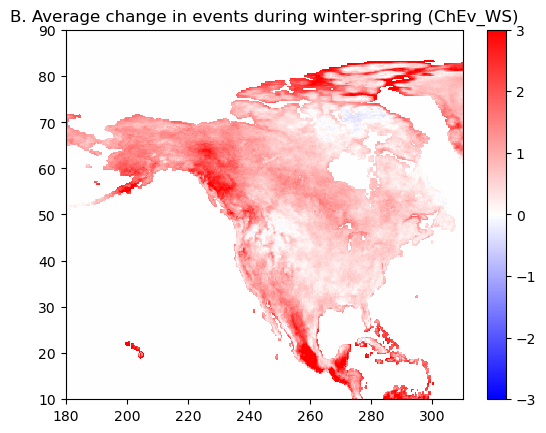

In [176]:
plt.pcolormesh(diff.lon,diff.lat,diff,vmin=-3,vmax=3,cmap='bwr')
plt.colorbar()
plt.title('B. Average change in events during winter-spring (ChEv_WS)')


In [177]:
B1 = diff_nonpt_perday * 180

Text(0.5, 1.0, 'B1. Mean (non-PT) increase')

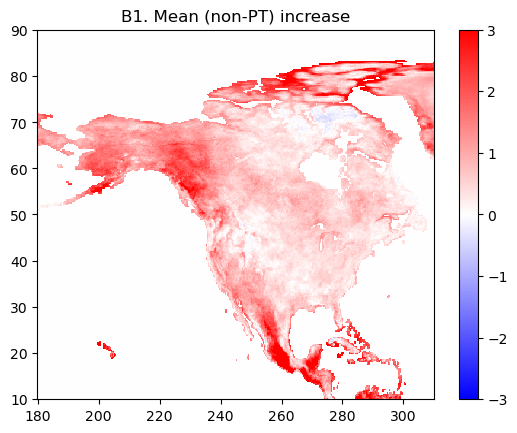

In [178]:
plt.pcolormesh(diff.lon,diff.lat,B1,vmin=-3,vmax=3,cmap='bwr')
plt.colorbar()
plt.title('B1. Mean (non-PT) increase')


In [179]:
B2 = (A2)+A3v3

In [180]:
B1.to_netcdf('diffs_extremes/ws_B1.nc')

In [181]:
B2.to_netcdf('diffs_extremes/ws_B2.nc')

Text(0.5, 1.0, 'B2. PT-related (frequency+nonlinearity) increase')

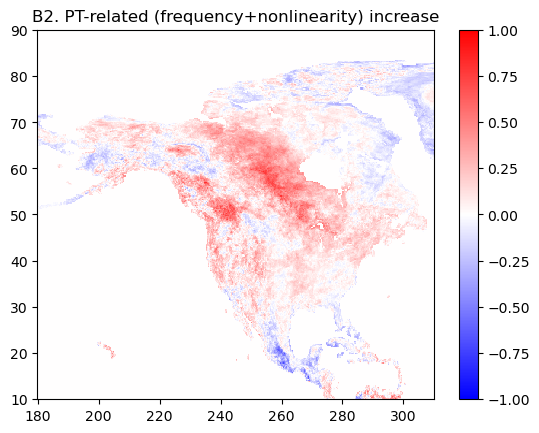

In [362]:
plt.pcolormesh(diff.lon,diff.lat,B2,vmin=-1,vmax=1,cmap='bwr')
plt.colorbar()
plt.title('B2. PT-related (frequency+nonlinearity) increase')


Text(0.5, 1.0, 'B2. PT-related (frequency+nonlinearity) increase')

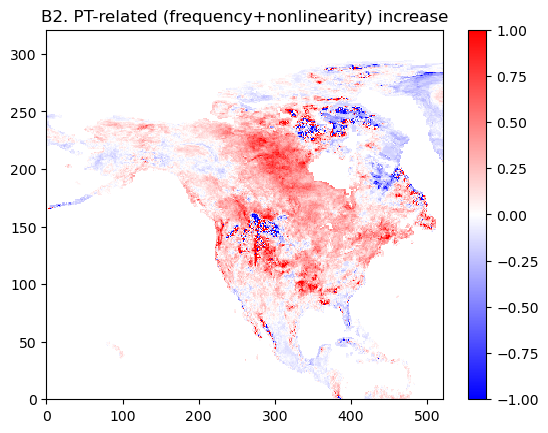

In [364]:
plt.pcolormesh(B2/diff,vmin=-1,vmax=1,cmap='bwr')
plt.colorbar()
plt.title('B2. PT-related (frequency+nonlinearity) increase')


Text(0.5, 1.0, 'B2. PT-related (frequency+nonlinearity) increase')

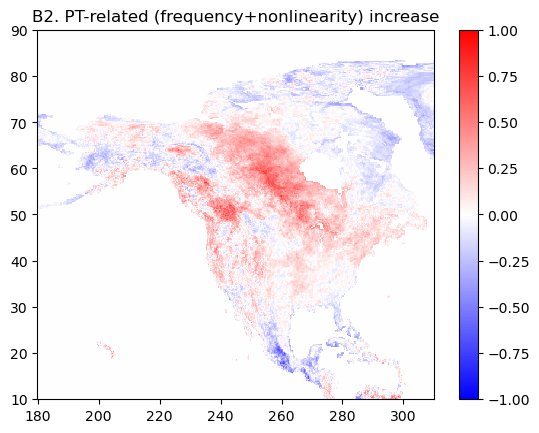

In [256]:
plt.pcolormesh(diff.lon,diff.lat,diff-B1,vmin=-1,vmax=1,cmap='bwr')
plt.colorbar()
plt.title('B2. PT-related (frequency+nonlinearity) increase')


# Geopotential change during PT

In [267]:
anoms = xr.open_dataset('/glade/derecho/scratch/jhayron/Data4WRsClimateChange/ProcessedDataReanalyses/Z500Anoms_ERA5.nc').Z_anom
# region for clustering
lat0 = 20; lat1 = 80; lon0 = 180; lon1 = 330

anoms = anoms.where((anoms.lat>=lat0)&(anoms.lat<=lat1)&\
                   (anoms.lon>=lon0)&(anoms.lon<=lon1),drop=True)

temp_temp = anoms.sel(time=df_test_season['1948':'1977'].index)
composite_past = temp_temp.mean('time')
temp_temp = anoms.sel(time=df_test_season['1994':'2023'].index)
composite_present = temp_temp.mean('time')
diff = composite_present-composite_past

Text(0.5, 1.0, 'Geopotential increase winter-spring')

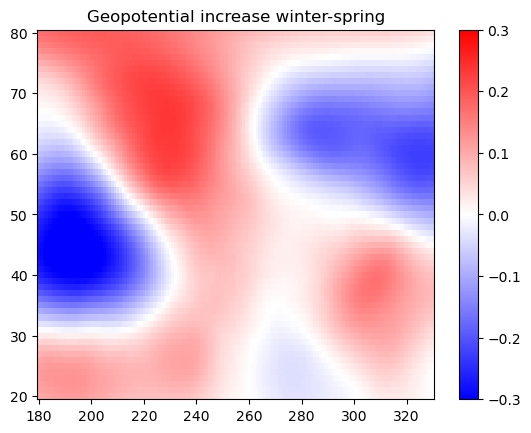

In [274]:
plt.pcolormesh(diff.lon,diff.lat,diff,vmin=-0.3,vmax=0.3,cmap='bwr')
plt.colorbar()
plt.title('Geopotential increase winter-spring')


In [269]:
df_wr = df_test_season[df_test_season['WR']==wr]
print(wr)

1


In [270]:
anoms = xr.open_dataset('/glade/derecho/scratch/jhayron/Data4WRsClimateChange/ProcessedDataReanalyses/Z500Anoms_ERA5.nc').Z_anom
anoms = anoms.sel(time=df_wr.index)
# region for clustering
lat0 = 20; lat1 = 80; lon0 = 180; lon1 = 330

anoms = anoms.where((anoms.lat>=lat0)&(anoms.lat<=lat1)&\
                   (anoms.lon>=lon0)&(anoms.lon<=lon1),drop=True)

temp_temp = anoms.sel(time=df_wr['1948':'1977'].index)
composite_past = temp_temp.mean('time')
temp_temp = anoms.sel(time=df_wr['1994':'2023'].index)
composite_present = temp_temp.mean('time')
diff_pt = composite_present-composite_past

Text(0.5, 1.0, 'Geopotential increase PT')

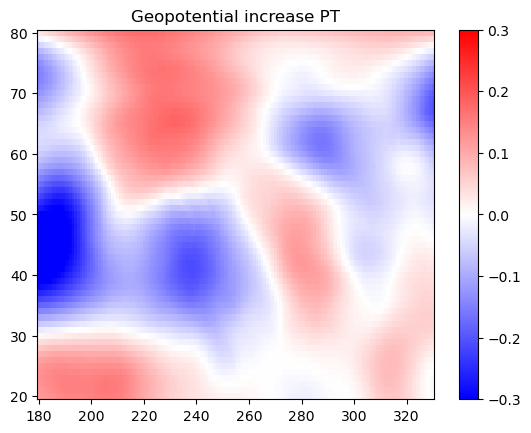

In [275]:
plt.pcolormesh(diff.lon,diff.lat,diff_pt,vmin=-0.3,vmax=0.3,cmap='bwr')
plt.colorbar()
plt.title('Geopotential increase PT')


Text(0.5, 1.0, 'Geopotential increase PT')

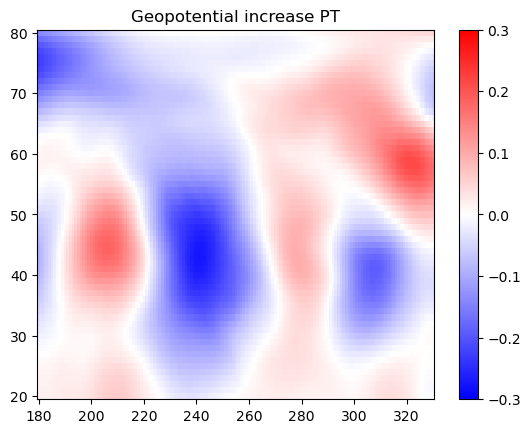

In [276]:
plt.pcolormesh(diff.lon,diff.lat,diff_pt-diff,vmin=-0.3,vmax=0.3,cmap='bwr')
plt.colorbar()
plt.title('Geopotential increase PT')


In [82]:
anoms = xr.open_dataset('/glade/derecho/scratch/jhayron/Data4WRsClimateChange/Temp/TMaxp90_ERA5.nc').MaxTemp

temp_temp = anoms.sel(time=df_test_season['1948':'1977'].index)
composite_past = temp_temp.sum('time')/30
temp_temp = anoms.sel(time=df_test_season['1994':'2023'].index)
composite_present = temp_temp.sum('time')/30
diff = composite_present-composite_past
diff_percent = diff/composite_past
yearly_anoms = anoms.groupby('time.year').sum(dim='time')
random_diffs = []

for seed in range(1000):
    np.random.seed(seed)
    years_random = np.random.choice(np.unique(df_test_season.year),size=60,replace=True)
    temp_temp = yearly_anoms.sel(year=years_random[:30])
    composite_past_random = temp_temp.sum('year')/30
    temp_temp = yearly_anoms.sel(year=years_random[30:])
    composite_present_random = temp_temp.sum('year')/30
    diff_random = composite_present_random-composite_past_random
    random_diffs.append(diff_random)

bootstrapped_diffs = xr.concat(random_diffs, dim='bootstrap_iteration')

q05 = bootstrapped_diffs.quantile(0.05,dim='bootstrap_iteration').drop_vars('quantile')
q95 = bootstrapped_diffs.quantile(0.95,dim='bootstrap_iteration').drop_vars('quantile')

ds_diff = xr.Dataset({'difference':copy.deepcopy(diff),
     'difference_percent':copy.deepcopy(diff_percent),
     'q05':q05,
     'q95':q95})

arr = ds_diff.difference.values
arr[(arr<=ds_diff.q95.values)&(arr>=ds_diff.q05.values)] = np.nan
ds_diff.difference.data = arr

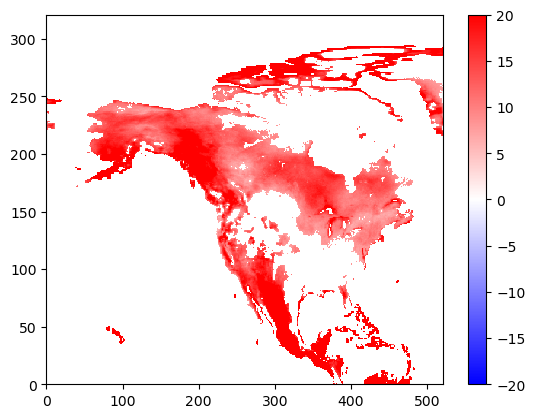

In [83]:
plt.pcolormesh(ds_diff.difference,vmin=-20,vmax=20,cmap='bwr')
plt.colorbar()

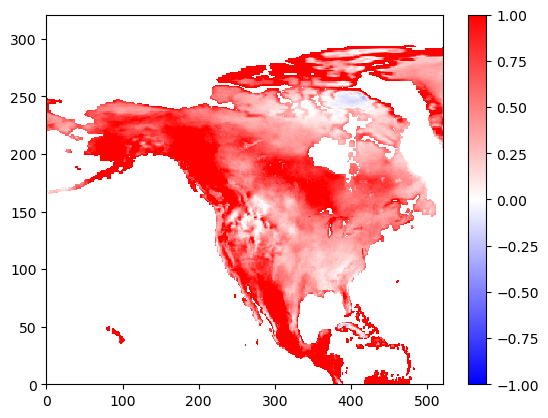

In [84]:
plt.pcolormesh(ds_diff.difference_percent,vmin=-1,vmax=1,cmap='bwr')
plt.colorbar()

In [85]:
ds_diff.to_netcdf('diffs_data/tx90_diff.nc')

# TX>90p: PT

In [16]:
df_wr = df_test_season[df_test_season['WR']==wr]
print(wr)

1


In [17]:
anoms = xr.open_dataset('/glade/derecho/scratch/jhayron/Data4WRsClimateChange/Temp/TMaxp90_ERA5.nc').MaxTemp
anoms = anoms.sel(time=df_wr.index)

temp_temp = anoms.sel(time=df_wr['1948':'1977'].index)
composite_past = temp_temp.sum('time')/30
temp_temp = anoms.sel(time=df_wr['1994':'2023'].index)
composite_present = temp_temp.sum('time')/30
diff = composite_present-composite_past
diff_percent = diff/composite_past
yearly_anoms = anoms.groupby('time.year').sum(dim='time')
yearly_anoms = yearly_anoms.reindex(year=np.sort(np.unique(df_test_season.index.year)))

In [44]:
random_diffs = []
anoms = xr.open_dataset('/glade/derecho/scratch/jhayron/Data4WRsClimateChange/Temp/TMaxp90_ERA5.nc').MaxTemp

for seed in range(1000):
    if seed%100==0:
        print(seed)
    np.random.seed(seed)
    len_subset_past = len(df_wr['1948':'1977'])
    len_subset_present = len(df_wr['1994':'2023'])
    random_df_past = df_test_season.loc[np.random.choice(df_test_season['1948':'1977'].index,len_subset_past)]
    random_df_present = df_test_season.loc[np.random.choice(df_test_season['1994':'2023'].index,len_subset_present)]

    temp_temp = anoms.sel(time=random_df_past.index)
    composite_past = temp_temp.sum('time')/30
    temp_temp = anoms.sel(time=random_df_present.index)
    composite_present = temp_temp.sum('time')/30
    diff = composite_present-composite_past
    random_diffs.append(diff)

bootstrapped_diffs = xr.concat(random_diffs, dim='bootstrap_iteration')

q05 = bootstrapped_diffs.quantile(0.05,dim='bootstrap_iteration').drop_vars('quantile')
q95 = bootstrapped_diffs.quantile(0.95,dim='bootstrap_iteration').drop_vars('quantile')

0
100
200
300
400
500
600
700
800
900


In [45]:
ds_diff = xr.Dataset({'difference':copy.deepcopy(diff),
     'difference_percent':copy.deepcopy(diff_percent),
     'q05':q05,
     'q95':q95})

arr = ds_diff.difference.values
arr[(arr<=ds_diff.q95.values)&(arr>=ds_diff.q05.values)] = np.nan
ds_diff.difference.data = arr
ds_diff.to_netcdf('diffs_data/tx90_pt_diff_bt2.nc')

In [ ]:
anoms = xr.open_dataset('/glade/derecho/scratch/jhayron/Data4WRsClimateChange/Temp/TMaxp90_ERA5.nc').MaxTemp
anoms = anoms.sel(time=df_wr.index)

random_diffs = []

for seed in range(1000):
    np.random.seed(seed)
    years_random = np.random.choice(np.unique(df_test_season.year),size=60,replace=True)
    temp_temp = yearly_anoms.sel(year=years_random[:30])
    composite_past_random = temp_temp.sum('year')/30
    temp_temp = yearly_anoms.sel(year=years_random[30:])
    composite_present_random = temp_temp.sum('year')/30
    diff_random = composite_present_random-composite_past_random
    random_diffs.append(diff_random)

bootstrapped_diffs = xr.concat(random_diffs, dim='bootstrap_iteration')

q05 = bootstrapped_diffs.quantile(0.05,dim='bootstrap_iteration').drop_vars('quantile')
q95 = bootstrapped_diffs.quantile(0.95,dim='bootstrap_iteration').drop_vars('quantile')


In [87]:
anoms = xr.open_dataset('/glade/derecho/scratch/jhayron/Data4WRsClimateChange/Temp/TMaxp90_ERA5.nc').MaxTemp
anoms = anoms.sel(time=df_wr.index)

temp_temp = anoms.sel(time=df_wr['1948':'1977'].index)
composite_past = temp_temp.sum('time')/30
temp_temp = anoms.sel(time=df_wr['1994':'2023'].index)
composite_present = temp_temp.sum('time')/30
diff = composite_present-composite_past
diff_percent = diff/composite_past
yearly_anoms = anoms.groupby('time.year').sum(dim='time')
yearly_anoms = yearly_anoms.reindex(year=np.sort(np.unique(df_test_season.index.year)))

random_diffs = []

for seed in range(1000):
    np.random.seed(seed)
    years_random = np.random.choice(np.unique(df_test_season.year),size=60,replace=True)
    temp_temp = yearly_anoms.sel(year=years_random[:30])
    composite_past_random = temp_temp.sum('year')/30
    temp_temp = yearly_anoms.sel(year=years_random[30:])
    composite_present_random = temp_temp.sum('year')/30
    diff_random = composite_present_random-composite_past_random
    random_diffs.append(diff_random)

bootstrapped_diffs = xr.concat(random_diffs, dim='bootstrap_iteration')

q05 = bootstrapped_diffs.quantile(0.05,dim='bootstrap_iteration').drop_vars('quantile')
q95 = bootstrapped_diffs.quantile(0.95,dim='bootstrap_iteration').drop_vars('quantile')

ds_diff = xr.Dataset({'difference':copy.deepcopy(diff),
     'difference_percent':copy.deepcopy(diff_percent),
     'q05':q05,
     'q95':q95})

arr = ds_diff.difference.values
arr[(arr<=ds_diff.q95.values)&(arr>=ds_diff.q05.values)] = np.nan
ds_diff.difference.data = arr

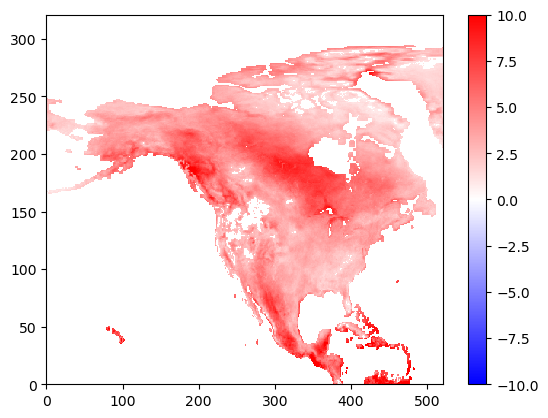

In [88]:
plt.pcolormesh(ds_diff.difference,vmin=-10,vmax=10,cmap='bwr')
plt.colorbar()

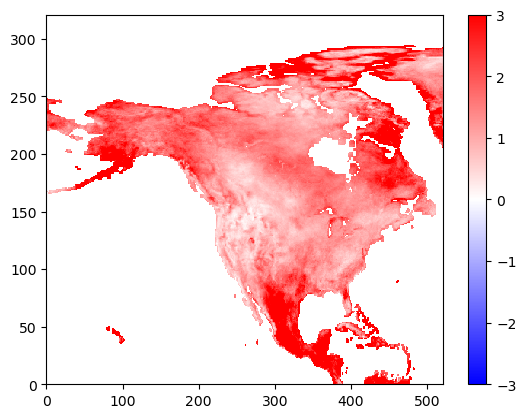

In [91]:
plt.pcolormesh(ds_diff.difference_percent,vmin=-3,vmax=3,cmap='bwr')
plt.colorbar()

In [90]:
ds_diff.to_netcdf('diffs_data/tx90_pt_diff.nc')

# Warm spells

In [92]:
anoms = xr.open_dataset('/glade/derecho/scratch/jhayron/Data4WRsClimateChange/Temp/warm_spells.nc').start_durations

temp_temp = anoms.sel(time=df_test_season['1948':'1977'].index)
composite_past = temp_temp.sum('time')/30
temp_temp = anoms.sel(time=df_test_season['1994':'2023'].index)
composite_present = temp_temp.sum('time')/30
diff = composite_present-composite_past
diff_percent = diff/composite_past
yearly_anoms = anoms.groupby('time.year').sum(dim='time')
random_diffs = []

for seed in range(1000):
    np.random.seed(seed)
    years_random = np.random.choice(np.unique(df_test_season.year),size=60,replace=True)
    temp_temp = yearly_anoms.sel(year=years_random[:30])
    composite_past_random = temp_temp.sum('year')/30
    temp_temp = yearly_anoms.sel(year=years_random[30:])
    composite_present_random = temp_temp.sum('year')/30
    diff_random = composite_present_random-composite_past_random
    random_diffs.append(diff_random)

bootstrapped_diffs = xr.concat(random_diffs, dim='bootstrap_iteration')

q05 = bootstrapped_diffs.quantile(0.05,dim='bootstrap_iteration').drop_vars('quantile')
q95 = bootstrapped_diffs.quantile(0.95,dim='bootstrap_iteration').drop_vars('quantile')

ds_diff = xr.Dataset({'difference':copy.deepcopy(diff),
     'difference_percent':copy.deepcopy(diff_percent),
     'q05':q05,
     'q95':q95})

arr = ds_diff.difference.values
arr[(arr<=ds_diff.q95.values)&(arr>=ds_diff.q05.values)] = np.nan
ds_diff.difference.data = arr

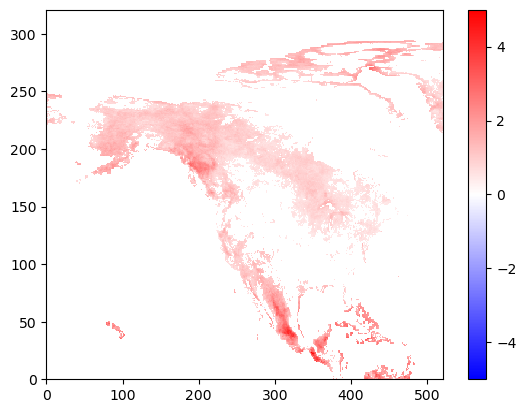

In [94]:
plt.pcolormesh(ds_diff.difference,vmin=-5,vmax=5,cmap='bwr')
plt.colorbar()

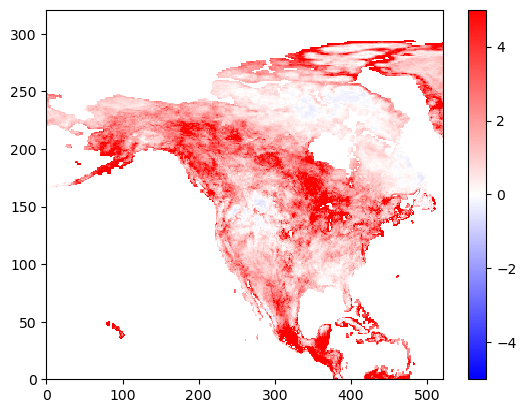

In [95]:
plt.pcolormesh(ds_diff.difference_percent,vmin=-5,vmax=5,cmap='bwr')
plt.colorbar()

In [96]:
ds_diff.to_netcdf('diffs_data/ws_diff.nc')

# Warm spells PT

In [47]:
df_wr = df_test_season[df_test_season['WR']==wr]
print(wr)

1


In [49]:
anoms = xr.open_dataset('/glade/derecho/scratch/jhayron/Data4WRsClimateChange/Temp/warm_spells.nc').start_durations
anoms = anoms.sel(time=df_wr.index)

temp_temp = anoms.sel(time=df_wr['1948':'1977'].index)
composite_past = temp_temp.sum('time')/30
temp_temp = anoms.sel(time=df_wr['1994':'2023'].index)
composite_present = temp_temp.sum('time')/30
diff = composite_present-composite_past
diff_percent = diff/composite_past
yearly_anoms = anoms.groupby('time.year').sum(dim='time')
yearly_anoms = yearly_anoms.reindex(year=np.sort(np.unique(df_test_season.index.year)))

In [50]:
random_diffs = []
anoms = xr.open_dataset('/glade/derecho/scratch/jhayron/Data4WRsClimateChange/Temp/warm_spells.nc').start_durations

for seed in range(1000):
    if seed%100==0:
        print(seed)
    np.random.seed(seed)
    len_subset_past = len(df_wr['1948':'1977'])
    len_subset_present = len(df_wr['1994':'2023'])
    random_df_past = df_test_season.loc[np.random.choice(df_test_season['1948':'1977'].index,len_subset_past)]
    random_df_present = df_test_season.loc[np.random.choice(df_test_season['1994':'2023'].index,len_subset_present)]

    temp_temp = anoms.sel(time=random_df_past.index)
    composite_past = temp_temp.sum('time')/30
    temp_temp = anoms.sel(time=random_df_present.index)
    composite_present = temp_temp.sum('time')/30
    diff = composite_present-composite_past
    random_diffs.append(diff)

bootstrapped_diffs = xr.concat(random_diffs, dim='bootstrap_iteration')

q05 = bootstrapped_diffs.quantile(0.05,dim='bootstrap_iteration').drop_vars('quantile')
q95 = bootstrapped_diffs.quantile(0.95,dim='bootstrap_iteration').drop_vars('quantile')

0
100
200
300
400
500
600
700
800
900


In [51]:
ds_diff = xr.Dataset({'difference':copy.deepcopy(diff),
     'difference_percent':copy.deepcopy(diff_percent),
     'q05':q05,
     'q95':q95})

arr = ds_diff.difference.values
arr[(arr<=ds_diff.q95.values)&(arr>=ds_diff.q05.values)] = np.nan
ds_diff.difference.data = arr
ds_diff.to_netcdf('diffs_data/ws_pt_diff_bt2.nc')

In [98]:
anoms = xr.open_dataset('/glade/derecho/scratch/jhayron/Data4WRsClimateChange/Temp/warm_spells.nc').start_durations
anoms = anoms.sel(time=df_wr.index)

temp_temp = anoms.sel(time=df_wr['1948':'1977'].index)
composite_past = temp_temp.sum('time')/30
temp_temp = anoms.sel(time=df_wr['1994':'2023'].index)
composite_present = temp_temp.sum('time')/30
diff = composite_present-composite_past
diff_percent = diff/composite_past
yearly_anoms = anoms.groupby('time.year').sum(dim='time')
yearly_anoms = yearly_anoms.reindex(year=np.sort(np.unique(df_test_season.index.year)))

random_diffs = []

for seed in range(1000):
    np.random.seed(seed)
    years_random = np.random.choice(np.unique(df_test_season.year),size=60,replace=True)
    temp_temp = yearly_anoms.sel(year=years_random[:30])
    composite_past_random = temp_temp.sum('year')/30
    temp_temp = yearly_anoms.sel(year=years_random[30:])
    composite_present_random = temp_temp.sum('year')/30
    diff_random = composite_present_random-composite_past_random
    random_diffs.append(diff_random)

bootstrapped_diffs = xr.concat(random_diffs, dim='bootstrap_iteration')

q05 = bootstrapped_diffs.quantile(0.05,dim='bootstrap_iteration').drop_vars('quantile')
q95 = bootstrapped_diffs.quantile(0.95,dim='bootstrap_iteration').drop_vars('quantile')

ds_diff = xr.Dataset({'difference':copy.deepcopy(diff),
     'difference_percent':copy.deepcopy(diff_percent),
     'q05':q05,
     'q95':q95})

arr = ds_diff.difference.values
arr[(arr<=ds_diff.q95.values)&(arr>=ds_diff.q05.values)] = np.nan
ds_diff.difference.data = arr

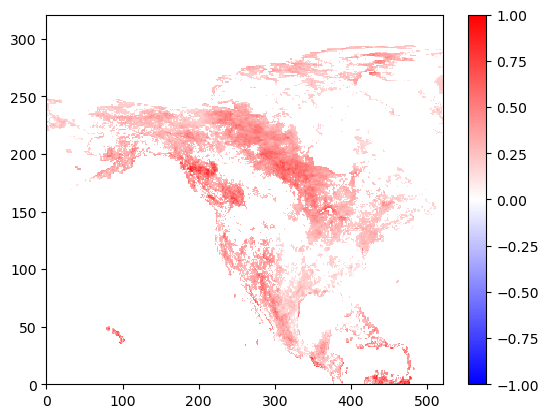

In [102]:
plt.pcolormesh(ds_diff.difference,vmin=-1,vmax=1,cmap='bwr')
plt.colorbar()

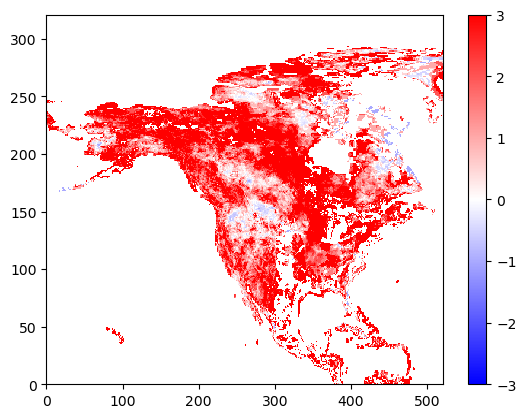

In [103]:
plt.pcolormesh(ds_diff.difference_percent,vmin=-3,vmax=3,cmap='bwr')
plt.colorbar()

In [104]:
ds_diff.to_netcdf('diffs_data/ws_pt_diff.nc')

# Tmin

In [72]:
anoms = xr.open_dataset('/glade/derecho/scratch/jhayron/Data4WRsClimateChange/Temp/TMin_ERA5_DailyAnoms_Std.nc').MinTemp
temp_temp = anoms.sel(time=df_test_season['1948':'1977'].index)
composite_past = temp_temp.mean('time')
temp_temp = anoms.sel(time=df_test_season['1994':'2023'].index)
composite_present = temp_temp.mean('time')
diff = (composite_present-composite_past)/composite_past

In [73]:
diff = (composite_present-composite_past)

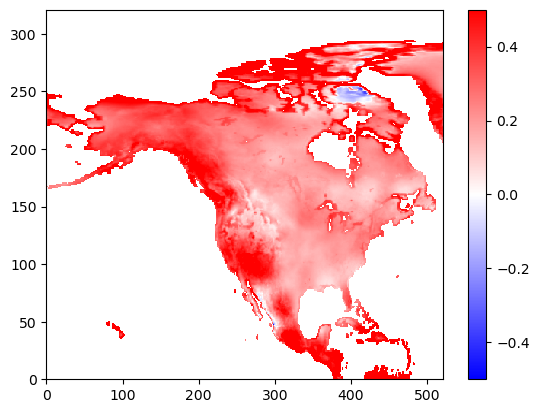

In [74]:
plt.pcolormesh(diff,vmin=-0.5,vmax=0.5,cmap='bwr')
plt.colorbar()

# warm spells

In [75]:
anoms = xr.open_dataset('/glade/derecho/scratch/jhayron/Data4WRsClimateChange/Temp/warm_spells.nc').start_durations
temp_temp = anoms.sel(time=df_test_season['1948':'1977'].index)
composite_past = temp_temp.sum('time')/30
temp_temp = anoms.sel(time=df_test_season['1994':'2023'].index)
composite_present = temp_temp.sum('time')/30
diff = (composite_present-composite_past)/composite_past

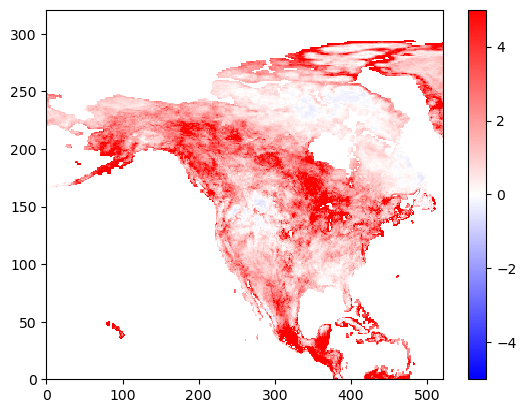

In [76]:
plt.pcolormesh(diff,vmin=-5,vmax=5,cmap='bwr')
plt.colorbar()

# TX>90p

In [77]:
anoms = xr.open_dataset('/glade/derecho/scratch/jhayron/Data4WRsClimateChange/Temp/TMaxp90_ERA5.nc').MaxTemp
temp_temp = anoms.sel(time=df_test_season['1948':'1977'].index)
composite_past = temp_temp.sum('time')/30
temp_temp = anoms.sel(time=df_test_season['1994':'2023'].index)
composite_present = temp_temp.sum('time')/30
diff = (composite_present-composite_past)/composite_past

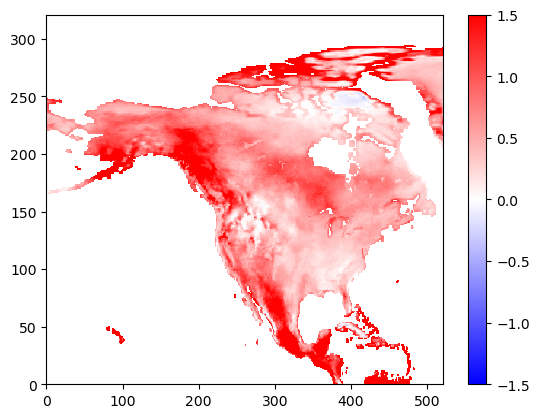

In [81]:
plt.pcolormesh(diff,vmin=-1.5,vmax=1.5,cmap='bwr')
plt.colorbar()

# TN>90p

In [82]:
anoms = xr.open_dataset('/glade/derecho/scratch/jhayron/Data4WRsClimateChange/Temp/TMinp90_ERA5.nc').MinTemp
temp_temp = anoms.sel(time=df_test_season['1948':'1977'].index)
composite_past = temp_temp.sum('time')/30
temp_temp = anoms.sel(time=df_test_season['1994':'2023'].index)
composite_present = temp_temp.sum('time')/30
diff = (composite_present-composite_past)/composite_past

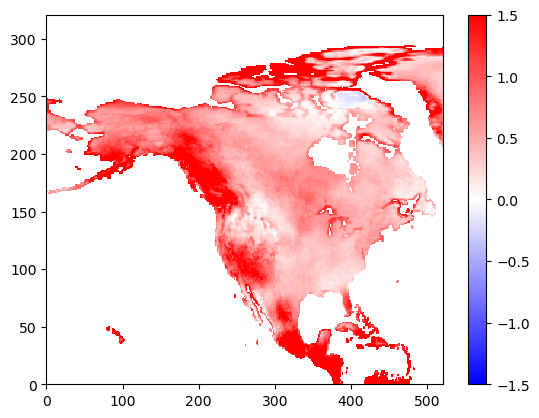

In [83]:
plt.pcolormesh(diff,vmin=-1.5,vmax=1.5,cmap='bwr')
plt.colorbar()

# summer days

In [101]:
anoms = xr.open_dataset('/glade/derecho/scratch/jhayron/Data4WRsClimateChange/Temp/TX25_ERA5.nc').MaxTemp
temp_temp = anoms.sel(time=df_test_season['1948':'1977'].index)
composite_past = temp_temp.sum('time')/30
temp_temp = anoms.sel(time=df_test_season['1994':'2023'].index)
composite_present = temp_temp.sum('time')/30
diff = (composite_present-composite_past)/composite_past

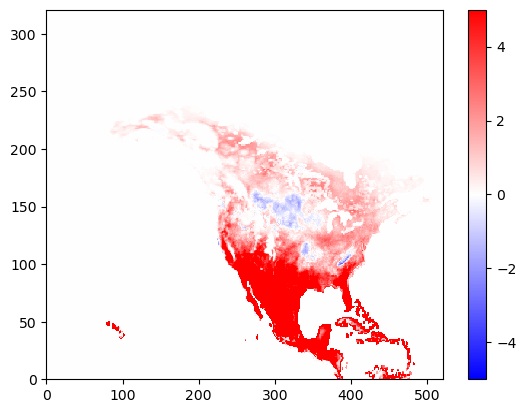

In [105]:
plt.pcolormesh((composite_present-composite_past),vmin=-5,vmax=5,cmap='bwr')
plt.colorbar()

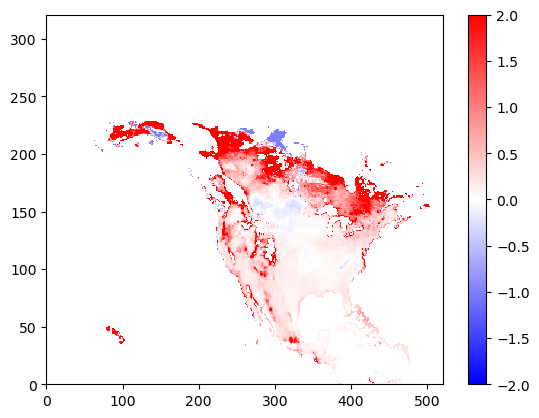

In [103]:
plt.pcolormesh(diff,vmin=-2,vmax=2,cmap='bwr')
plt.colorbar()

# number of wet days

In [84]:
anoms = xr.open_dataset('/glade/derecho/scratch/jhayron/Data4WRsClimateChange/Precip/ERA5/wet_days.nc').DailyPrecip

temp_temp = anoms.sel(time=df_test_season['1948':'1977'].index)
composite_past = temp_temp.sum('time')/30
temp_temp = anoms.sel(time=df_test_season['1994':'2023'].index)
composite_present = temp_temp.sum('time')/30
diff = (composite_present-composite_past)/composite_past

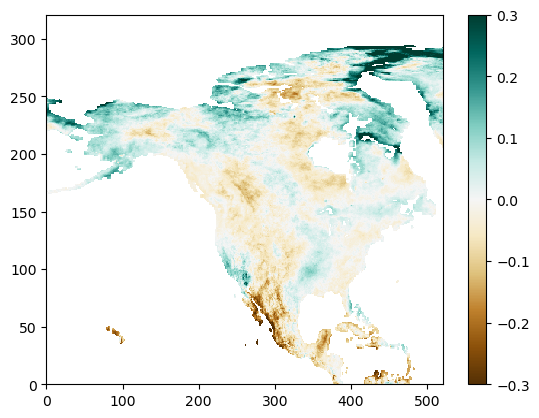

In [87]:
plt.pcolormesh(diff,vmin=-0.3,vmax=0.3,cmap='BrBG')
plt.colorbar()

# number of dry days

In [88]:
anoms = xr.open_dataset('/glade/derecho/scratch/jhayron/Data4WRsClimateChange/Precip/ERA5/dry_days.nc').DailyPrecip

temp_temp = anoms.sel(time=df_test_season['1948':'1977'].index)
composite_past = temp_temp.sum('time')/30
temp_temp = anoms.sel(time=df_test_season['1994':'2023'].index)
composite_present = temp_temp.sum('time')/30
diff = (composite_present-composite_past)/composite_past

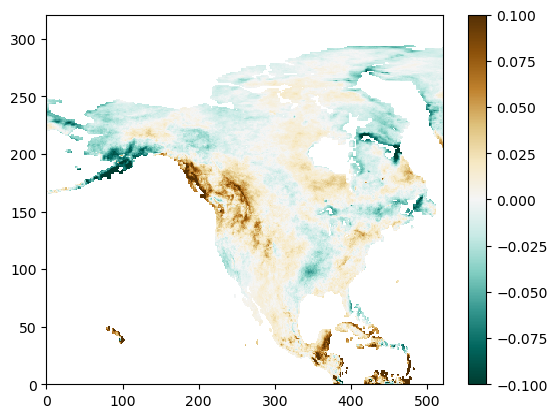

In [90]:
plt.pcolormesh(diff,vmin=-0.1,vmax=0.1,cmap='BrBG_r')
plt.colorbar()

# Average duration of wet spells

In [93]:
anoms = xr.open_dataset('/glade/derecho/scratch/jhayron/Data4WRsClimateChange/Precip/ERA5/dur_wet_spells.nc')['__xarray_dataarray_variable__']

temp_temp = anoms.sel(time=df_test_season['1948':'1977'].index)
composite_past = temp_temp.mean('time')
temp_temp = anoms.sel(time=df_test_season['1994':'2023'].index)
composite_present = temp_temp.mean('time')
diff = (composite_present-composite_past)/composite_past

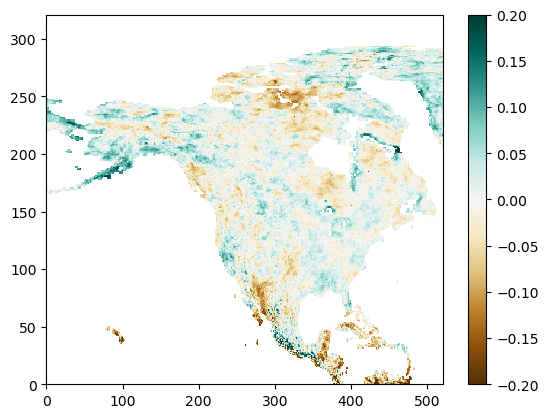

In [98]:
plt.pcolormesh(diff,vmin=-0.2,vmax=0.2,cmap='BrBG')
plt.colorbar()

# Average duration of dry spells

In [99]:
anoms = xr.open_dataset('/glade/derecho/scratch/jhayron/Data4WRsClimateChange/Precip/ERA5/dur_dry_spells.nc')['__xarray_dataarray_variable__']

temp_temp = anoms.sel(time=df_test_season['1948':'1977'].index)
composite_past = temp_temp.mean('time')
temp_temp = anoms.sel(time=df_test_season['1994':'2023'].index)
composite_present = temp_temp.mean('time')
diff = (composite_present-composite_past)/composite_past

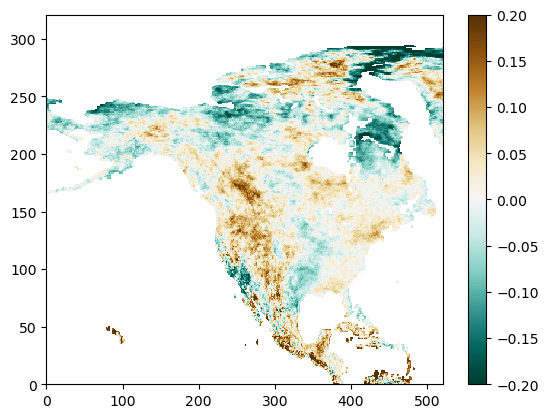

In [100]:
plt.pcolormesh(diff,vmin=-0.2,vmax=0.2,cmap='BrBG_r')
plt.colorbar()